In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.neighbors import NearestNeighbors
from pynndescent import NNDescent

from timer import timer
# import logging
# logging.basicConfig(level=logging.DEBUG)

In [2]:
def lorenz(t, u, p=10, b=8/3, r=28):
    x, y, z = u

    dxdt = -p * x + p * y
    dydt = -x * z + r * x - y
    dzdt =  x * y - b * z

    return np.array([dxdt, dydt, dzdt])

In [3]:
sol = solve_ivp(lorenz, (0,40), [0.1, 0.1, 0.1], t_eval=np.linspace(0, 40, 1000000))

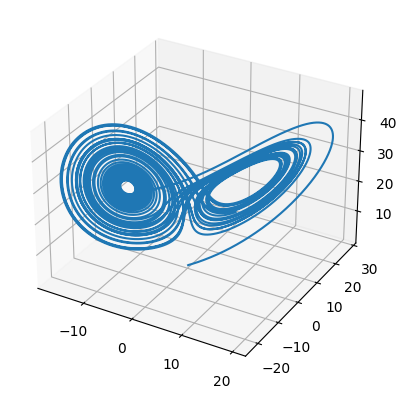

In [4]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot(*list(sol.y))
plt.show()

In [5]:
def embed(ts, E, tau):
    block = np.zeros([test.shape[0]-(E-1)*tau,E])

    for i in range(E):
        block[:,i] = ts[i*tau:ts.shape[0]-(E-i-1)*tau:tau]

    return block

def simplex(train, test, knn, E, tau=1, Tp=1):
    train_embed = embed(train, E, tau)
    test_embed = embed(test, E, tau)

    distances, indices = knn(train_embed[:-Tp,:], test_embed[:-Tp,:])
    
    weights = np.exp(-np.divide(distances, distances.min(axis=1)[:,np.newaxis]))
    weights = np.divide(weights, np.sum(weights, axis=1)[:,np.newaxis])
    pred = np.sum(train[indices+Tp] * weights, axis=1)
    
    return pred

def eval(train, test, knn, E, tau=1, Tp=1):
    train_embed = embed(train, E, tau)
    test_embed = embed(test, E, tau)

    with timer() as t:
        distances, indices = knn(train_embed[:-Tp,:], test_embed[:-Tp,:])
    
    weights = np.exp(-np.divide(distances, distances.min(axis=1)[:,np.newaxis]))
    weights = np.divide(weights, np.sum(weights, axis=1)[:,np.newaxis])
    pred = np.sum(train[indices+Tp] * weights, axis=1)
    
    mape = mean_absolute_percentage_error(test[:pred.shape[0]], pred)
    
    print(f"k-NN: {t.elapse:.5f}s, MAPE: {mape:.5f}")

In [6]:
E = 3
Tp = 1
tau = 1

train = sol.y[0,:sol.y.shape[1]//2]
test = sol.y[0,sol.y.shape[1]//2:]

In [7]:
def brute(train_embed, test_embed):
    with timer("Brute-force build index"):
        index = NearestNeighbors(n_neighbors=E+1, algorithm="brute").fit(train_embed)
    with timer("Brute-force query"):
        distances, indices = index.kneighbors(test_embed)
    
    return distances, indices

def kd_tree(train_embed, test_embed):
    with timer("KD-tree build index"):
        index = NearestNeighbors(n_neighbors=E+1, algorithm="kd_tree").fit(train_embed)
    with timer("KD-tree query"):
        distances, indices = index.kneighbors(test_embed)
    
    return distances, indices

def ball_tree(train_embed, test_embed):
    with timer("Ball-tree build index"):
        index = NearestNeighbors(n_neighbors=E+1, algorithm="ball_tree").fit(train_embed)
    with timer("Ball-tree query"):
        distances, indices = index.kneighbors(test_embed)
    
    return distances, indices

def nn_descent(train_embed, test_embed):
    index = NNDescent(train_embed)
    index.query(test_embed, k=E+1)

for E in range(1, 5):
    print(f"E={E}")
    eval(train, test, kd_tree, E)
    eval(train, test, ball_tree, E)

E=1
k-NN: 0.32551s, MAPE: 0.00089
k-NN: 0.30537s, MAPE: 0.00089
E=2
k-NN: 0.48256s, MAPE: 0.00098
k-NN: 0.47264s, MAPE: 0.00098
E=3
k-NN: 0.65382s, MAPE: 0.00104
k-NN: 0.70522s, MAPE: 0.00104
E=4
k-NN: 0.79231s, MAPE: 0.00111
k-NN: 0.89003s, MAPE: 0.00111


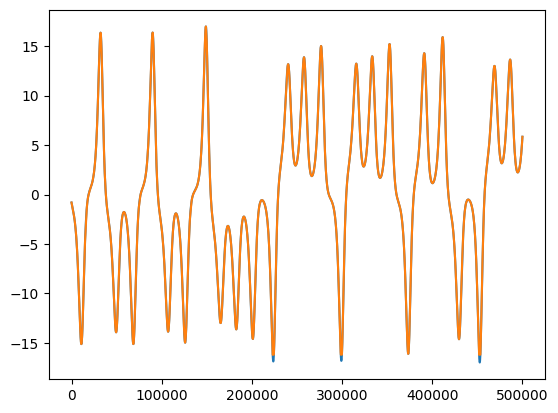

In [8]:
pred = simplex(train, test, ball_tree, 3)

plt.plot(test)
plt.plot(pred)